##  Let us begin

Can add descriptions later for users to load interactively. 


In [ ]:
!nvidia-smi -L

In [ ]:
# import os
# import torch
# !pip install GPUtil

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import numpy as np
import argparse
import torch
import sys
import importlib as ipb
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import GPUtil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]
      
    def pickle(self, key_save):
        f = open(key_save, 'wb')
        pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
        f.close()

    def unpickle(self, key_save):
        with open(key_save, 'rb') as f:
            return pickle.load(f)

    def add_result(self, run, result):
        assert len(result) == 4
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Train: {result[:, 1].max():.2f}')
            print(f'Highest Test: {result[:, 3].max():.2f}')
            # Same as highest train, as we have no validation data
            print(f'  Final Train: {result[argmax, 1]:.2f}') 
            print(f'   Final Test: {result[argmax, 3]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)
            best_results = []
            for r in result:
                train = r[:, 1].max().item()
                test = r[:, 3].max().item()
                train2 = r[r[:, 1].argmax(), 1].item()
                test2 = r[r[:, 1].argmax(), 3].item()
                best_results.append((train, test, train2, test2))

            best_result = torch.tensor(best_results)

            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 1]
            print(f'Highest Test: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 2]
            print(f'  Final Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 3]
            print(f'   Final Test: {r.mean():.2f} ± {r.std():.2f}')


def test(model, train_loader, test_loader):
    model.eval()
    loader = {0: train_loader, 1:test_loader}
    accuracies = []
    with torch.no_grad():
        for data_loader in loader.values():
            correct = 0
            total = 0
            loss = 0
            for i, (images, labels) in enumerate(data_loader):
                if args.FC:
                    images = images.reshape(-1, input_size).to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                cost = nn.CrossEntropyLoss()
                loss += cost(outputs, labels).item()
            accuracies.append(loss/(i+1))
            accuracies.append(correct/total)
    return accuracies # train_accu & test accu

### Training function (include SVI)

In [ ]:
def train(model, images, labels):
    model.train()
    out = model(images)
    cost = nn.CrossEntropyLoss()
    loss = cost(out, labels)
    loss.backward()
    return loss.item()


def train_SVI(model, images, labels):
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    model.train()
    out = model(images)
    cost = nn.CrossEntropyLoss(reduction = 'sum')
    loss = cost(out, labels)
    #### New lines for SVI ####
    model.turn_on_off_grad(on = False) 
    # print('#### Grad of model params before SVI')
    # for name, param in model.named_parameters():
    #     if param.grad is not None:
    #         print(name, param.grad.norm())
    #### End #####
    loss.backward()
    #### New lines for SVI ####
    loss_tilde = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        loss_tilde += (Xlplus1*Xlplus1grad).sum()/Xlplus1.size(0)
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # print('#### Grad of model params after SVI')
    # for name, param in model.named_parameters():
    #     if param.grad is not None:
    #         print(name, param.grad.norm())
    # raise Exception('Stop here')
    model.on_training = False  # To avoid additional .retain_grad()
    #### End #####
    return loss.item()

### VGG-16

In [ ]:
class VGG16(nn.Module):
    def __init__(self,num_classes = 10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        for layer in self.features:
            x = layer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class VGG16_SVI(nn.Module):
    def __init__(self,num_classes = 10):
        super(VGG16_SVI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        #### New lines for SVI ####
        self.layers_Xtilde = []
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on

    def append_to_layers_Xtilde(self, conv, x):
        if self.on_training:
            x_tmp = x.detach().clone().to(device)
            if len(conv) > 1:
                for conv_ in conv:
                    x_tmp = conv_(x_tmp)
                    if isinstance(conv_, nn.AdaptiveAvgPool2d):
                        x_tmp = torch.flatten(x_tmp, 1)
            else:
                x_tmp = conv[0](x_tmp)
            self.layers_Xtilde.append(x_tmp)
    
    def append_to_layers_grad(self, x):
        if self.on_training:
            x.retain_grad()
            self.layers_grad.append(x)
    #### End #####
    
    def forward(self, x):
        # Manually breaks down SVI into pre-activation and post-activation
        # (0) Conv2d
        self.append_to_layers_Xtilde([self.features[0]], x)
        x = self.features[0](x)
        x = self.features[1](x)
        self.append_to_layers_grad(x)
        # (2) Conv2d
        self.append_to_layers_Xtilde([self.features[2]], x)
        x = self.features[2](x)
        x = self.features[3](x)
        self.append_to_layers_grad(x)
        # (4) MaxPool2d + (5) Conv2d
        self.append_to_layers_Xtilde([self.features[4], self.features[5]], x)
        x = self.features[4](x)
        x = self.features[5](x)
        x = self.features[6](x)
        self.append_to_layers_grad(x)
        # (7) Conv2d
        self.append_to_layers_Xtilde([self.features[7]], x)
        x = self.features[7](x)
        x = self.features[8](x)
        self.append_to_layers_grad(x)
        # (9) MaxPool2d + (10) Conv2d
        self.append_to_layers_Xtilde([self.features[9], self.features[10]], x)
        x = self.features[9](x)
        x = self.features[10](x)
        x = self.features[11](x)
        self.append_to_layers_grad(x)
        # (12) Conv2d
        self.append_to_layers_Xtilde([self.features[12]], x)
        x = self.features[12](x)
        x = self.features[13](x)
        self.append_to_layers_grad(x)
        # (14) Conv2d
        self.append_to_layers_Xtilde([self.features[14]], x)
        x = self.features[14](x)
        x = self.features[15](x)
        self.append_to_layers_grad(x)
        # (16) MaxPool2d + (17) Conv2d
        self.append_to_layers_Xtilde([self.features[16],self.features[17]], x)
        x = self.features[16](x)
        x = self.features[17](x)
        x = self.features[18](x)
        self.append_to_layers_grad(x)
        # (19) Conv2d
        self.append_to_layers_Xtilde([self.features[19]], x)
        x = self.features[19](x)
        x = self.features[20](x)
        self.append_to_layers_grad(x)
        # (21) Conv2d
        self.append_to_layers_Xtilde([self.features[21]], x)
        x = self.features[21](x)
        x = self.features[22](x)
        self.append_to_layers_grad(x)
        # (23) MaxPool2d + (24) Conv2d
        self.append_to_layers_Xtilde([self.features[23], self.features[24]], x)
        x = self.features[23](x)
        x = self.features[24](x)
        x = self.features[25](x)
        self.append_to_layers_grad(x)
        # (26) Conv2d
        self.append_to_layers_Xtilde([self.features[26]], x)
        x = self.features[26](x)
        x = self.features[27](x)
        self.append_to_layers_grad(x)
        # (28) Conv2d
        self.append_to_layers_Xtilde([self.features[28]], x)
        x = self.features[28](x)
        x = self.features[29](x)
        self.append_to_layers_grad(x)
        # (30) MaxPool2d + avgpool + flatten + (0) Linear
        self.append_to_layers_Xtilde([self.features[30],self.avgpool, self.classifier[0]], x)
        x = self.features[30](x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier[0](x)
        x = self.classifier[1](x)
        self.append_to_layers_grad(x)
        # (2) Dropout + (3) Linear
        self.append_to_layers_Xtilde([self.classifier[2], self.classifier[3]], x)
        x = self.classifier[2](x)
        x = self.classifier[3](x)
        x = self.classifier[4](x)
        self.append_to_layers_grad(x)
        # (5) Dropout + (6) Linear
        self.append_to_layers_Xtilde([self.classifier[5], self.classifier[6]], x)
        x = self.classifier[5](x)
        x = self.classifier[6](x)
        self.append_to_layers_grad(x)
        return x

In [ ]:
from torchvision import models
model_pretrained = models.vgg16(pretrained = True)

def vgg_16_load(SVI = False, load_pretrain = False):
    if load_pretrain:
        num_c = 1000
        model = VGG16_SVI(num_c) if SVI else VGG16(num_c)
        model.load_state_dict(model_pretrained.state_dict())
        model.classifier[6] = nn.Linear(4096, 10)
    else:
        num_c = 10
        model = VGG16_SVI(num_c) if SVI else VGG16(num_c)
    return model.to(device) 
    

In [ ]:
# mod1 = vgg_16_load(SVI = True, load_pretrain = True)
# x = torch.randn(10, 3, 32, 32).to(device)
# out = mod1(x)
# out.shape
# print(len(mod1.layers_Xtilde), len(mod1.layers_grad))

### Utility function, including data functions

In [ ]:
def mem_report():
    if device.type == 'cuda':
        GPUs = GPUtil.getGPUs()
        for i, gpu in enumerate(GPUs):
            print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(
                i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    else:
        print("CPU RAM Free: "
              + humanize.naturalsize(psutil.virtual_memory().available))

In [ ]:
import torchvision
import torchvision.transforms as transforms
def subset_data(data,frac=1):
    # Randomly subset a fraction of data from total data
    np.random.seed(1103)
    idx = np.random.choice(len(data),int(frac*len(data)),replace=False)
    return torch.utils.data.Subset(data,idx)
data_fixed = 'CIFAR10_batched' # 'MNIST_batched' or 'CIFAR10_batched'
if 'MNIST' in data_fixed:
    train_dataset0 = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)
    test_dataset0 = torchvision.datasets.MNIST(root = './data',
                                              train = False,
                                              transform = transforms.Compose([
                                                      transforms.Resize((32,32)),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                              download=True)
    num_classes = 10
    in_channels = 1
else:
    # NOTE, CIFAR10 has color channels, so input size = 3*32*32 with FC net
    train_dataset0 = torchvision.datasets.CIFAR10(root='./data', 
                                              train=True, 
                                              transform=transforms.ToTensor(),  
                                              download=True)
    test_dataset0 = torchvision.datasets.CIFAR10(root='./data', 
                                              train=False, 
                                              transform=transforms.ToTensor())
    num_classes = 10 
    in_channels = 3
input_size = torch.prod(torch.tensor(train_dataset0[0][0].shape)).item()
frac=0.1 if 'MNIST' in data_fixed else 0.2
frac = 1
train_dataset = subset_data(train_dataset0,frac=frac)
test_dataset = subset_data(test_dataset0,frac=frac)
print(len(train_dataset))
print(len(test_dataset))
# Data loader (i.e., split to batches) see below

Start testing

In [ ]:
SVI_ls = [True, True, False]  # If False, use ordinary SGD or Adam
SVI_pause = [False, True, False]  # If True, only SVI to warm start
SVI_ls = [True, False]
SVI_pause = [False, False]
optim_ls = ['SGD']
load_pretrain = True # Load pretrained VGG16 to transfer learning
lr, hidden_channels = 0.001, 512
FC_only = False  # Use all FC layers if True, o/w use LeNet
dataname = data_fixed
if FC_only == False:
    dataname = data_fixed + 'VGG16_'
num_runs = 3
batch_size = 128
num_epochs = 20
num_epochs = 5
num_log_steps = len(train_dataset) // batch_size # Evaluate loss every X iteration/mini-batches
num_log_steps = int(num_log_steps/20)
if __name__ == "__main__":
    result_dict = {'SVI-SGD': [],
                           'SVI_warmstart-SGD': [],
                           'SGD': [],
                           'SVI-Adam': [],
                           'SVI_warmstart-Adam': [],
                           'Adam': []}
    Final_result = {}  # For quick check at the end of training
    for use_SVI, pause_SVI in zip(SVI_ls, SVI_pause):
        for optim_name in optim_ls:
            parser = argparse.ArgumentParser(
                description=dataname)
            parser.add_argument('--log_steps', type=int, default=num_log_steps)
            parser.add_argument('--num_layers', type=int, default=4)
            parser.add_argument('--dropout', type=float, default=0.25)
            parser.add_argument('--lr', type=float, default=lr)
            parser.add_argument('--momentum', type=float, default=0.95)
            parser.add_argument(
                '--epochs', type=int, default=num_epochs)  # Change to 100
            parser.add_argument(
                '--batch_size', type=int, default=batch_size)
            parser.add_argument('--runs', type=int,
                                default=num_runs)
            parser.add_argument('--SVI', type=bool, default=use_SVI)
            parser.add_argument('--FC', type=bool, default=FC_only)
            parser.add_argument(
                '--optimizer', type=str, default=optim_name)
            args = parser.parse_args(args=[])
            args.hidden_channels = hidden_channels
            print(args)
            # Get data loader from dataset
            train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=batch_size,
                                                       shuffle=True)
            test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                      batch_size=batch_size,
                                                      shuffle=False)
            logger = Logger(args.runs, args)
            results_over_runs = {}
            for run in range(args.runs):
                accu_at_run = []
                # Initiatiate new model per run
                torch.manual_seed(1103 + run)
                args.SVI = use_SVI
                model = vgg_16_load(args.SVI, load_pretrain = load_pretrain)
                if args.optimizer == 'SGD':
                    optimizer = torch.optim.SGD(
                        model.parameters(), lr=args.lr, momentum=args.momentum, nesterov=True)
                else:
                    optimizer = torch.optim.Adam(
                        model.parameters(), lr=args.lr)
                for epoch in range(1, 1 + args.epochs):
                    iter_per_epoch = int(len(train_dataset) / batch_size) + 1
                    frac_stop = 0.1
                    if num_epochs > 20:
                        frac_stop = 0.05
                    pause_threshold = int(
                        frac_stop * iter_per_epoch * args.epochs)
                    if device.type == 'cuda':
                        # Useful to avoid GPU allocation excess
                        torch.cuda.empty_cache()
                    print(f"LR is {optimizer.param_groups[0]['lr']}")
                    for i, (images, labels) in enumerate(train_loader):
                        current_itr = ((epoch - 1) * iter_per_epoch) + i + 1
                        if pause_SVI and current_itr > pause_threshold:
                            args.SVI = False
                            if current_itr <= pause_threshold + 1:
                                # Reinitialize optimizer to avoid gradient issue in Adam
                                sdict = model.state_dict()
                                print(
                                    '############ Pause SVI from now on ############')
                                model = vgg_16_load(args.SVI, load_pretrain = load_pretrain)
                                model.load_state_dict(sdict)
                                model = model.to(device)
                                if args.optimizer == 'SGD':
                                    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, 
                                                                momentum=args.momentum, 
                                                                nesterov=True)
                                else:
                                    optimizer = torch.optim.Adam(
                                        model.parameters(), lr=args.lr)
                        optimizer.zero_grad()
                        if args.FC:
                            images = images.reshape(-1, input_size).to(device)
                        images = images.to(device)
                        labels = labels.to(device)
                        loss = train_SVI(model, images, labels) if args.SVI else train(model, images, labels)
                        optimizer.step()
                        # Test at each iteration
                        if (i+1) % args.log_steps == 0:
                            print('Testing')
                            if args.SVI:
                                print(f'SVI-{args.optimizer} training at batch {i}, epoch {epoch}')
                            else:
                                print(f'{args.optimizer} training at batch {i}, epoch {epoch}')
                            # Do so because training data has too many images, and evaluation thus takes too long.
                            train_loader_sub = torch.utils.data.DataLoader(dataset=subset_data(train_dataset0,frac=0.1),
                                                       batch_size=batch_size,
                                                       shuffle=True)
                            result = test(model, train_loader_sub, test_loader)
                            logger.add_result(run, result)
                            train_loss, train_acc, test_loss, test_acc = result
                            accu_at_run += [result]
                            print(f'Run: {run + 1:02d}, '
                                  f'Epoch: {epoch:02d}, '
                                  f'Train loss: {train_loss:.4f}', 
                                  f'Test loss: {test_loss:.4f}', 
                                  f'Train: {100 * train_acc:.2f}%,'
                                  f'Test: {100 * test_acc:.2f}%')
                # Save model after training over all epochs
                results_over_runs[f'lr={args.lr}@Run{run+1}'] = accu_at_run
                logger.print_statistics(run)
                # Save results
                if use_SVI:
                    SVI_prefix = 'SVI_warmstart-' if pause_SVI else 'SVI-'
                else:
                    SVI_prefix = ''
                key = f'{SVI_prefix}{optim_name}'
                key_save = f'{SVI_prefix}{optim_name}-{args.num_layers}layers-{args.hidden_channels}nodes-{args.lr}LR'
                key_save = dataname + key_save
                # # Save it to file, but need not now because only one run.
                # logger.pickle(key_save)
                result_dict[key].append(results_over_runs)
                # Final train and test accuracy
                Final_result[key] = accu_at_run[-1]
                epoch_suff = '_more_epoch' if num_epochs > 20 else ''
                # with open(f"{key_save}_loss_together_SVI_only.json", "w") as outfile:
                #     json.dump(result_dict, outfile)
            logger.print_statistics()

## Visualize (has the option to load from saved file)

In [1]:
# Finally, plot train loss, test loss, train acc, test acc
def get_mean(result_dict, stop_epoch, return_full=True):
    # Stop_epoch: determine when to stop computing the values.
    full_res = [np.array(i)[:stop_epoch] for i in result_dict.values()]
    if return_full:
        full_mean = np.round(np.mean(full_res, axis=0), 2)
        full_std = np.round(np.std(full_res, axis=0), 2)
        return [full_mean, full_std]  # For plot
    else:
        idx = [np.argmax(i[:, 1])
               for i in full_res]  # Collect idx at which valid is highest
        vals = [i[j] for i, j in zip(full_res, idx)]
        means = np.round(np.mean(vals, axis=0), decimals=2)
        stds = np.round(np.std(vals, axis=0), decimals=2)
        return [means, stds]  # For table
def get_ave_results(key):
    SVI_mean, SVI_std = get_mean(result_dict[key][0], stop_epoch=tot_epoch)
    ave_results = {'train_loss': SVI_mean[:, 0], 'train_acc': SVI_mean[:, 1],
                    'test_loss': SVI_mean[:, 2], 'test_acc': SVI_mean[:, 3],
                    'train_loss_std': SVI_std[:, 0], 'train_acc_std': SVI_std[:, 1],   
                    'test_loss_std': SVI_std[:, 2], 'test_acc_std': SVI_std[:, 3]}
    return ave_results

def plot_on_axes(train_mean, train_std, test_mean, test_std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    xaxes = np.arange(1, len(train_mean) + 1)
    xaxes *= num_log_steps
    ax.plot(xaxes, train_mean, color = color, label = label + ' train')
    ax.plot(xaxes, test_mean, color = color, linestyle = '--', label = label + ' test')
    ax.fill_between(xaxes, train_mean - train_std, train_mean + train_std, alpha = 0.2, color = color)
    ax.fill_between(xaxes, test_mean - test_std, test_mean + test_std, alpha = 0.2, color = color)
    ax.legend()

In [2]:
save = False # Save results to avoid re-running
if save:
    ave_results_SGD = get_ave_results('SGD')
    ave_results_SVI = get_ave_results('SVI-SGD')
    # Save results
    full_dict = {'SVI-SGD': ave_results_SVI, 'SGD': ave_results_SGD}
    import pickle
    with open(f"VGG16_initial.pkl", "wb") as outfile:
        pickle.dump(full_dict, outfile)

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
full_dict = pickle.load(open(f"VGG16_initial.pkl", "rb"))
full_dict.keys()
ave_results_SVI = full_dict['SVI-SGD']
ave_results_SGD = full_dict['SGD']
num_log_steps = 50000 // 128 # Evaluate loss every X iteration/mini-batches
freq = 20
num_log_steps = int(num_log_steps/freq)
tot_epoch = freq*5 # How many total times I evaluated loss on test sample

By mini-batch 57 out of 1900 mini-batches
####################
SGD train loss mean: 0.99 +/- 0.03
SVI train loss mean: 1.03 +/- 0.02
####################
SGD test loss mean: 1.0 +/- 0.02
SVI test loss mean: 1.03 +/- 0.02
####################
SGD train error mean: 0.35 +/- 0.01
SVI train error mean: 0.36 +/- 0.01
####################
SGD test error mean: 0.35 +/- 0.01
SVI test error mean: 0.36 +/- 0.01


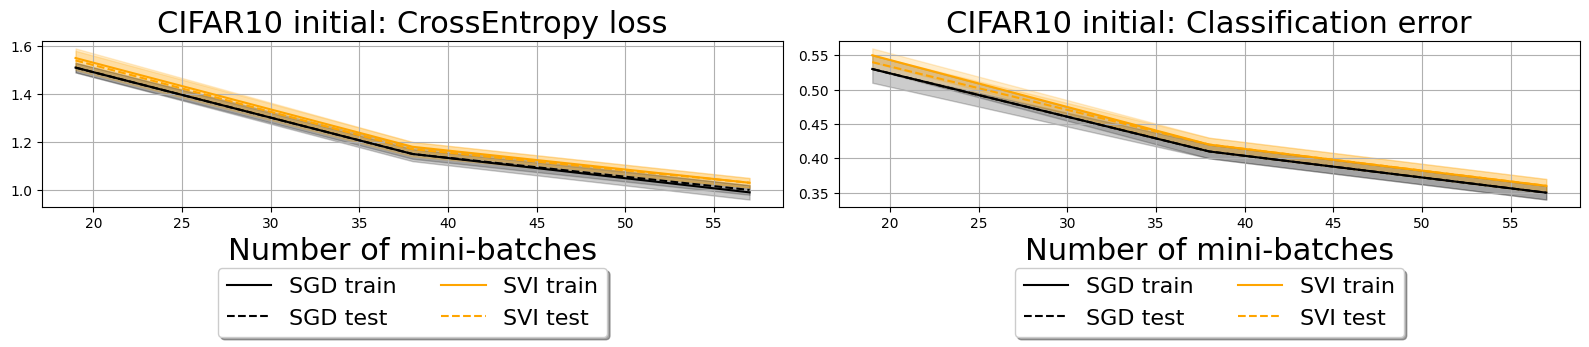

In [6]:
# Plot losses and error
stop = 3
print(f'By mini-batch {stop*num_log_steps} out of {tot_epoch*num_log_steps} mini-batches')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI["train_loss"][stop-1]} +/- {ave_results_SVI["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI["test_loss"][stop-1]} +/- {ave_results_SVI["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI["train_acc"][stop-1]} +/- {ave_results_SVI["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI["test_acc"][stop-1]} +/- {ave_results_SVI["test_acc_std"][stop-1]}')



fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('CIFAR10 initial: CrossEntropy loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('CIFAR10 initial: Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                fancybox=True, shadow=True, ncol=2, fontsize=fsize-6)
    a.grid()
    a.set_xlabel('Number of mini-batches', fontsize=fsize)
fig.tight_layout()
plt.show()

By mini-batch 760 out of 1900 mini-batches
####################
SGD train loss mean: 0.31 +/- 0.01
SVI train loss mean: 0.38 +/- 0.01
####################
SGD test loss mean: 0.45 +/- 0.01
SVI test loss mean: 0.49 +/- 0.01
####################
SGD train error mean: 0.09999999999999998 +/- 0.0
SVI train error mean: 0.13 +/- 0.0
####################
SGD test error mean: 0.16000000000000003 +/- 0.0
SVI test error mean: 0.17000000000000004 +/- 0.0


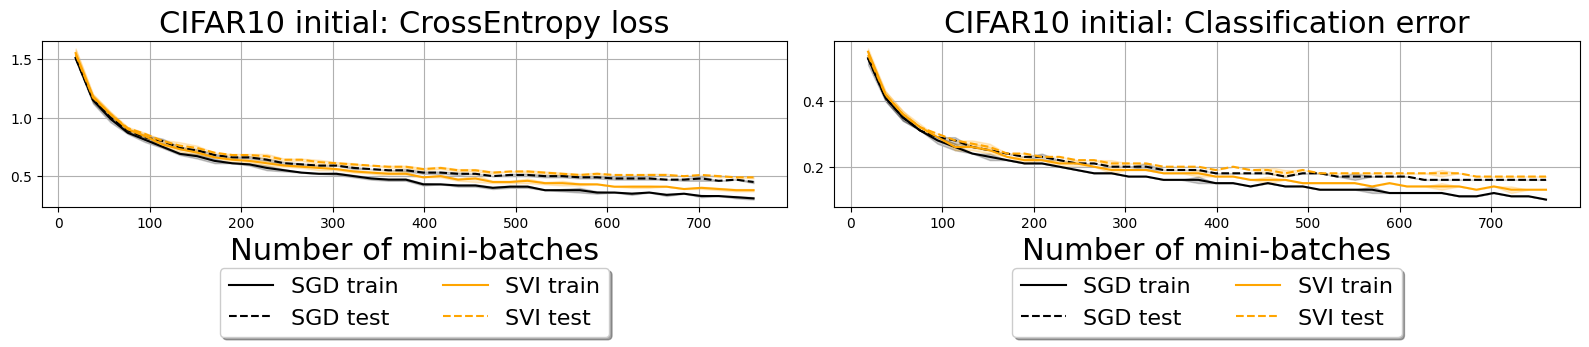

In [4]:
# Plot losses and error
stop = int(0.4*tot_epoch)
print(f'By mini-batch {stop*num_log_steps} out of {tot_epoch*num_log_steps} mini-batches')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI["train_loss"][stop-1]} +/- {ave_results_SVI["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI["test_loss"][stop-1]} +/- {ave_results_SVI["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI["train_acc"][stop-1]} +/- {ave_results_SVI["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI["test_acc"][stop-1]} +/- {ave_results_SVI["test_acc_std"][stop-1]}')



fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('CIFAR10 initial: CrossEntropy loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('CIFAR10 initial: Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                fancybox=True, shadow=True, ncol=2, fontsize=fsize-6)
    a.grid()
    a.set_xlabel('Number of mini-batches', fontsize=fsize)
fig.tight_layout()
plt.show()

By mini-batch 1900 out of 1900 mini-batches
####################
SGD train loss mean: 0.11 +/- 0.01
SVI train loss mean: 1.53 +/- 0.03
####################
SGD test loss mean: 0.44 +/- 0.01
SVI test loss mean: 1.51 +/- 0.03
####################
SGD train error mean: 0.030000000000000027 +/- 0.0
SVI train error mean: 0.54 +/- 0.02
####################
SGD test error mean: 0.13 +/- 0.0
SVI test error mean: 0.54 +/- 0.02


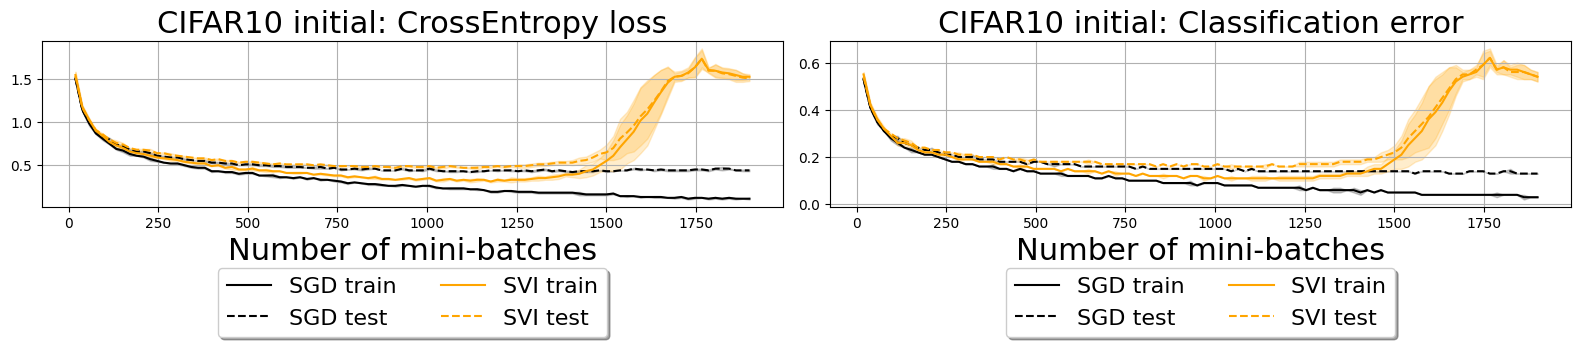

In [5]:
# Plot losses and error
stop = tot_epoch
print(f'By mini-batch {stop*num_log_steps} out of {tot_epoch*num_log_steps} mini-batches')
print('####################')
print(f'SGD train loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SVI train loss mean: {ave_results_SVI["train_loss"][stop-1]} +/- {ave_results_SVI["train_loss_std"][stop-1]}')
print('####################')
print(f'SGD test loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI test loss mean: {ave_results_SVI["test_loss"][stop-1]} +/- {ave_results_SVI["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train error mean: {1-ave_results_SGD["train_acc"][stop-1]} +/- {ave_results_SGD["train_acc_std"][stop-1]}')
print(f'SVI train error mean: {1-ave_results_SVI["train_acc"][stop-1]} +/- {ave_results_SVI["train_acc_std"][stop-1]}')
print('####################')
print(f'SGD test error mean: {1-ave_results_SGD["test_acc"][stop-1]} +/- {ave_results_SGD["test_acc_std"][stop-1]}')
print(f'SVI test error mean: {1-ave_results_SVI["test_acc"][stop-1]} +/- {ave_results_SVI["test_acc_std"][stop-1]}')



fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fsize = 22
args = {'ax': ax[0]}
color_labels = {0: ['black', 'SGD'], 1: ['orange', 'SVI']}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('CIFAR10 initial: CrossEntropy loss', fontsize=fsize)

args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI]):
    train_key, test_key, suffix = 'train_acc', 'test_acc', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(1-ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 1-ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('CIFAR10 initial: Classification error', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                fancybox=True, shadow=True, ncol=2, fontsize=fsize-6)
    a.grid()
    a.set_xlabel('Number of mini-batches', fontsize=fsize)
fig.tight_layout()
plt.show()